In [1]:
# code to generate plots for functional overlap analyses between HI-III, HI-III-PSN and functional networks
import huri_db_utils
import numpy, pandas, math, scipy.stats
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
% matplotlib inline

path = '../data/katjas_data/PSN_analysis/'
figure_path = '../figures/'
hi_color = (155/255, 97/255, 153/255)

def get_fold_change_data(network_name,path,edge_weight,fctPSN,fctPSN_type):

    if '_PSN' in network_name:
        infile = path + 'nw_overlaps_' + fctPSN_type + '_sum_edge_weights_' + edge_weight + '_' + network_name + fctPSN + '.txt'
    else:
        infile = path + 'nw_overlaps_' + fctPSN_type + '_sum_edge_weights_PPI_' + network_name + fctPSN + '.txt'
    data = pandas.read_table(infile,header=0)
    data['foldchange'] = data.apply(lambda x: x['sum_edge_weights_real']/x['mean_sum_edge_weights_rand'] 
                                              if x['mean_sum_edge_weights_rand'] > 0 and x['pvalue'] <= 0.05
                                              else numpy.nan,
                                   axis=1)
    data['fc_err_down'] = data['foldchange'] - data.apply(lambda x: x['sum_edge_weights_real']/x['97.5perc_sum_edge_weights_rand'] 
                                              if x['97.5perc_sum_edge_weights_rand'] > 0
                                              else 0,
                                   axis=1)
    data['fc_err_up'] = data.apply(lambda x: x['sum_edge_weights_real']/x['2.5perc_sum_edge_weights_rand'] 
                                              if x['2.5perc_sum_edge_weights_rand'] > 0
                                              else x['foldchange']*100,
                                   axis=1) - data['foldchange']
    
    return data
    

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42  # TrueType fonts for ease of editing in illustrator
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7.0
mpl.rcParams['savefig.dpi'] = 500


In [3]:
# plot to compare number of edges at different JS cutoffs in real PSN to random PSNs
# save num edges at a given JS cutoff in one list for all random networks
nw_name = 'HI-III_PSN'
cutoffs = [0.001,0.01] + [i/10.0 for i in range(1,11)]
num_rand = 100
# get data for real network
network_file = path + nw_name + '.txt'
PSN = pandas.read_table(network_file,header=0)
real_count = []
for cutoff in cutoffs:
    real_count.append(PSN.loc[PSN['Jaccard_similarity'] >= cutoff,].shape[0])

#read in the counts from the random networks
rand_file = path + nw_name + '_rand_edge_count_per_JScutoff.npy'
rand_count_matrix = numpy.load(rand_file)
rand_count_matrix = rand_count_matrix[:,1:]

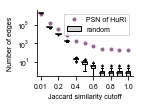

In [4]:
plt.figure(figsize=(2,1.5))
p1, = plt.plot(range(1,len(cutoffs)),real_count[1:],marker='o',markersize=3,linestyle='',color=hi_color)

boxprops = dict(color='black')
flierprops = dict(marker='.',markerfacecolor='black',markersize='2',linestyle='')
medianprops = dict(color='black',linestyle='-',linewidth=1.5)
pa = plt.boxplot(rand_count_matrix,positions=range(1,len(cutoffs)),
           boxprops=boxprops,flierprops=flierprops,medianprops=medianprops,patch_artist=True)
for box in pa['boxes']:
    box.set(facecolor='lightgrey')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Jaccard similarity cutoff')
plt.ylabel('Number of edges')
plt.xticks(range(1,len(cutoffs),2),[cutoffs[i] for i in range(1,len(cutoffs),2)])
ax.set_yscale('log', basey=10, nonposy='clip')
plt.legend([p1,pa['boxes'][0]],['PSN of HuRI','random'],loc='upper right')
plt.tight_layout()
outfile = figure_path + 'num_edges_real_vs_random_PSN_by_JS_cutoff.png'
plt.savefig(outfile,fmt='png',dpi=1000)
outfile = figure_path + 'num_edges_real_vs_random_PSN_by_JS_cutoff.pdf'
plt.savefig(outfile,fmt='pdf',dpi=300)
plt.show()


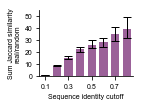

In [5]:
# plot SeqIdent overlaps for HI-III only
fctPSN = '_SeqIdent'
fctPSN_type = 'per_PCCcutoffs'
nw_name = 'HI-III_PSN'
plt.figure(figsize=(2,1.5))

data = get_fold_change_data(nw_name,path,'Jaccard_similarity',fctPSN,fctPSN_type)
plt.bar(range(data.shape[0]),data['foldchange'],
        yerr=[data['fc_err_down'],data['fc_err_up']],
        width=0.7,color=hi_color,ecolor='black',error_kw={'elinewidth':1},capsize=4.)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(0,data.shape[0],2),[data['cutoff'][i] for i in range(0,data.shape[0],2)])
plt.xlim([-0.5,7.5])
plt.yticks(range(0,60,10),range(0,60,10))
plt.ylim([0,55])
#plt.legend(loc='upper left',fontsize=12)
plt.xlabel('Sequence identity cutoff')
plt.ylabel('Sum Jaccard similarity\nreal/random')

plt.tight_layout()
filename = 'FC_SeqIdent_HI-III_PSN_only'
outfile = figure_path + filename + '.png'
plt.savefig(outfile,fmt='png',dpi=300)
outfile = figure_path + filename + '.pdf'
plt.savefig(outfile,fmt='pdf',dpi=300)

plt.show()


In [7]:
# plot trends of connectivity for inreasing JS cutoffs for PSN edges to correspond to PPIs when split by 
# PPIs without SIPs, involving 1 SIP or both interacting proteins being SIP
# annotate to PSN which edges are in HI-III
PSN = pandas.read_table(path + 'HI-III_PSN.txt',header=0,usecols=['gene_a','gene_b','Jaccard_similarity'])
hi_iii = huri_db_utils.load_nw_hi_iii('ensembl_gene_id',fmt='pandas',cache='off')
PSN = PSN.merge(hi_iii,how='left',right_on=['ensembl_gene_id_a','ensembl_gene_id_b'],left_on=['gene_a','gene_b'])
PSN['PPI'] = ~PSN['ensembl_gene_id_a'].isnull()
PSN = PSN.drop(['ensembl_gene_id_a','ensembl_gene_id_b','in_screen_1','in_screen_2','in_screen_3','in_screen_4',
                'in_screen_5','in_screen_6','in_screen_7','in_screen_8','in_screen_9','in_assay_v1','in_assay_v2',
                'in_assay_v6'],axis=1)
SIPs = hi_iii.loc[hi_iii['ensembl_gene_id_a'] == hi_iii['ensembl_gene_id_b'],'ensembl_gene_id_a'].values
# mark all PPIs that involve a SIP
PSN['gene_a_SIP'] = PSN['gene_a'].isin(SIPs)
PSN['gene_b_SIP'] = PSN['gene_b'].isin(SIPs)


In [8]:
hi_iii = huri_db_utils.load_nw_hi_iii('ensembl_gene_id',fmt='pandas',cache='off')
hi_iii = hi_iii.merge(PSN,how='left',left_on=['ensembl_gene_id_a','ensembl_gene_id_b'],right_on=['gene_a','gene_b'])
hi_iii['PSN'] = ~hi_iii['Jaccard_similarity'].isnull()
hi_iii.drop(['PPI','gene_a_SIP','gene_b_SIP','gene_a','gene_b'],axis=1,inplace=True)
hi_iii.head()

,ensembl_gene_id_a,ensembl_gene_id_b,in_assay_v1,in_assay_v2,in_assay_v6,in_screen_1,in_screen_2,in_screen_3,in_screen_4,in_screen_5,in_screen_6,in_screen_7,in_screen_8,in_screen_9,Jaccard_similarity,PSN
0,ENSG00000000005,ENSG00000061656,False,True,False,False,False,False,False,False,True,False,False,False,NaN,False
1,ENSG00000000005,ENSG00000099968,False,True,False,False,False,False,False,True,False,False,False,False,NaN,False
2,ENSG00000000005,ENSG00000104765,True,False,False,False,False,True,False,False,False,False,False,False,0.038462,True
3,ENSG00000000005,ENSG00000105383,False,False,True,False,False,False,False,False,False,False,False,True,NaN,False
4,ENSG00000000005,ENSG00000114455,False,False,True,False,False,False,False,False,False,False,False,True,NaN,False


In [9]:
# print Fraction of edges in HI-III at a certain Jaccard similarity cutoff
cutoffs = [i/10.0 for i in range(11)]
for cutoff in cutoffs:
    print(cutoff,hi_iii.loc[hi_iii['Jaccard_similarity']>cutoff,].shape[0]/hi_iii.shape[0])

0.0 0.5894919058760867
0.1 0.0537769407825905
0.2 0.012726131370199166
0.3 0.004108885464817668
0.4 0.001407673724057905
0.5 0.0003994749757461622
0.6 0.00028533926839011586
0.7 0.00028533926839011586
0.8 0.00026631665049744145
0.9 0.00022827141471209268
1.0 0.0


[0.007853548950075194, 0.0058566037735849055, 0.004206098843322818, 0.0031762837480148226, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.008026834506105222, 0.011139622641509434, 0.015904311251314408, 0.015881418740074114, 0.0010193679918450561, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0020237277436363976, 0.003954716981132075, 0.009069400630914827, 0.02170460561143462, 0.021406727828746176, 0.029880478087649404, 0.05976095617529881, 0.06451612903225806, 0.06280193236714976, 0.0]


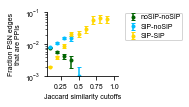

In [10]:
cutoffs = [i/10.0 for i in range(1,11)]

plt.figure(figsize=(2.7,1.5))
fracs = []
yerr = []
for c,cutoff in enumerate(cutoffs):
    num_edges = PSN.loc[PSN['Jaccard_similarity'] >= cutoff,].shape[0]
    num_intersect = PSN.loc[(PSN['Jaccard_similarity'] >= cutoff) & PSN['PPI'] & (~PSN['gene_a_SIP']) & (~PSN['gene_b_SIP']),].shape[0]
    if num_edges > 0:
        frac = (num_intersect/float(num_edges))
        error = numpy.sqrt((frac*(1-frac))/num_edges)
    else:
        frac = 0
        error = 0
    fracs.append(frac)
    yerr.append(error)
print(fracs)

plt.errorbar(cutoffs,fracs,yerr=yerr,marker='o',markersize=3,color='darkgreen',linestyle='',capsize=2,label='noSIP-noSIP')

fracs = []
yerr = []
for c,cutoff in enumerate(cutoffs):
    num_edges = PSN.loc[PSN['Jaccard_similarity'] >= cutoff,].shape[0]
    num_intersect = PSN.loc[(PSN['Jaccard_similarity'] >= cutoff) & 
                            PSN['PPI'] & 
                            (((PSN['gene_a_SIP']) & (~PSN['gene_b_SIP'])) | 
                             ((~PSN['gene_a_SIP']) & (PSN['gene_b_SIP']))),].shape[0]
    if num_edges > 0:
        frac = (num_intersect/float(num_edges))
        error = numpy.sqrt((frac*(1-frac))/num_edges)
    else:
        frac = 0
        error = 0
    fracs.append(frac)
    yerr.append(error)
print(fracs)

plt.errorbar(cutoffs,fracs,yerr=yerr,marker='o',markersize=3,color='deepskyblue',linestyle='',capsize=2,label='SIP-noSIP')

fracs = []
yerr = []
for c,cutoff in enumerate(cutoffs):
    num_edges = PSN.loc[PSN['Jaccard_similarity'] >= cutoff,].shape[0]
    num_intersect = PSN.loc[(PSN['Jaccard_similarity'] >= cutoff) & 
                            PSN['PPI'] & PSN['gene_a_SIP'] & PSN['gene_b_SIP'],].shape[0]
    if num_edges > 0:
        frac = (num_intersect/float(num_edges))
        error = numpy.sqrt((frac*(1-frac))/num_edges)
    else:
        frac = 0
        error = 0
    fracs.append(frac)
    yerr.append(error)
print(fracs)

plt.errorbar(cutoffs,fracs,yerr=yerr,marker='o',markersize=3,color='gold',linestyle='',capsize=2,label='SIP-SIP')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yscale('log', basey=10, nonposy='clip')
plt.ylim([0.001,0.1])
plt.xticks([0.25,0.5,0.75,1.0],[0.25,0.5,0.75,1.0])
plt.xlabel('Jaccard similarity cutoffs')
plt.ylabel('Fraction PSN edges\nthat are PPIs')
lgd = plt.legend(handletextpad=0.1,borderpad=0.2,bbox_to_anchor=(1.05, 1.05))
plt.tight_layout()

filename = 'HI-III_PSN_overlap_by_SIP'
outfile = figure_path + filename + '.png'
plt.savefig(outfile,fmt='png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
outfile = figure_path + filename + '.pdf'
plt.savefig(outfile,fmt='pdf',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

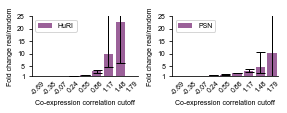

In [11]:
# plot enrichments of HI-III and HI-III_PSN for SEEK
fctPSN = '_SeekPSN'
fctPSN_type = 'per_PCCcutoffs'
networks = [['HI-III'],['HI-III_PSN']]
network_names = [['HuRI'],['PSN']]
colors = [[hi_color],[hi_color]]
plt.figure(figsize=(4,1.5))

for s,sp in enumerate(networks):
    plt.subplot(1,2,s+1)
    for n,nw_name in enumerate(sp):
        data = get_fold_change_data(nw_name,path,'Jaccard_similarity',fctPSN,fctPSN_type)
        plt.bar([i+0.8*n for i in range(data.shape[0])],data['foldchange'],
                yerr=[data['fc_err_down'],data['fc_err_up']],
                width=0.8,color=colors[s][n],ecolor='black',error_kw={'elinewidth':1},capsize=4.5,label=network_names[s][n])

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_tick_params(length=0.)
    plt.xticks([i for i in range(data.shape[0])],data['cutoff'],rotation=45)
    plt.xlim([-0.5,8.5])
    plt.ylim([1,25])
    plt.yticks([1,5,10,15,20,25],[1,5,10,15,20,25])
    plt.legend(loc='upper left')
    plt.xlabel('Co-expression correlation cutoff')
    plt.ylabel('Fold change real/random')

plt.tight_layout()
filename = 'FC_SeekPSN'
outfile = figure_path + filename + '.png'
plt.savefig(outfile,fmt='png',dpi=300)
outfile = figure_path + filename + '.pdf'
plt.savefig(outfile,fmt='pdf',dpi=300)

plt.show()

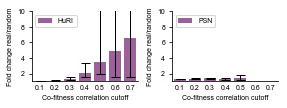

In [12]:
# plot enrichments of HI-III and HI-III_PSN for SEEK
fctPSN = '_coFitnessPSN'
fctPSN_type = 'per_PCCcutoffs'
networks = [['HI-III'],['HI-III_PSN']]
network_names = [['HuRI'],['PSN']]
colors = [[hi_color],[hi_color]]
plt.figure(figsize=(4,1.5))

for s,sp in enumerate(networks):
    plt.subplot(1,2,s+1)
    for n,nw_name in enumerate(sp):
        data = get_fold_change_data(nw_name,path,'Jaccard_similarity',fctPSN,fctPSN_type)
        plt.bar([i+0.8*n for i in range(data.shape[0])],data['foldchange'],
                yerr=[data['fc_err_down'],data['fc_err_up']],
                width=0.8,color=colors[s][n],ecolor='black',error_kw={'elinewidth':1},capsize=4.5,label=network_names[s][n])

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_tick_params(length=0.)
    plt.xticks([i for i in range(data.shape[0])],data['cutoff'])
    plt.xlim([-0.5,6.5])
    plt.ylim([1,10])
    plt.yticks([2,4,6,8,10],[2,4,6,8,10])
    plt.legend(loc='upper left')
    plt.xlabel('Co-fitness correlation cutoff')
    plt.ylabel('Fold change real/random')

plt.tight_layout()
filename = 'FC_coFitPSN'
outfile = figure_path + filename + '.png'
plt.savefig(outfile,fmt='png',dpi=300)
outfile = figure_path + filename + '.pdf'
plt.savefig(outfile,fmt='pdf',dpi=300)

plt.show()

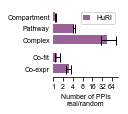

In [13]:
# plot enrichments of HI-III for localization, pathways, BioPlex, co-expression and co-fitness
datasets = []
networks = ['HI-III']
edge_weight = 'Jaccard_similarity'
fctPSN = ''
fctPSN_types = ['coAnnot','per_PCCcutoffs']
fct_nws = ['_SeekPSN','_coFitnessPSN']
xmin = 1
xmax = 100

for n,nw_name in enumerate(networks):
    for fctPSN_type in fctPSN_types:
        if fctPSN_type == 'per_PCCcutoffs':
            for fct_nw in fct_nws:
                datasets.append(get_fold_change_data(nw_name,path,edge_weight,fct_nw,fctPSN_type))
        else:
            datasets.append(get_fold_change_data(nw_name,path,edge_weight,fctPSN,fctPSN_type))

plt.figure(figsize=(1.8,1.6))
fold_changes = []
err_up = []
err_down = []
data = datasets[0]
fold_changes.append(data.loc[data['fct_dataset'] == 'cell_atlas_localization_info','foldchange'].values[0])
fold_changes.append(data.loc[data['fct_dataset'] == 'reactome_pathway_info','foldchange'].values[0])
fold_changes.append(data.loc[data['fct_dataset'] == 'Bioplex2.0_complex_info','foldchange'].values[0])
err_up.append(data.loc[data['fct_dataset'] == 'cell_atlas_localization_info','fc_err_up'].values[0])
err_up.append(data.loc[data['fct_dataset'] == 'reactome_pathway_info','fc_err_up'].values[0])
err_up.append(data.loc[data['fct_dataset'] == 'Bioplex2.0_complex_info','fc_err_up'].values[0])
err_down.append(data.loc[data['fct_dataset'] == 'cell_atlas_localization_info','fc_err_down'].values[0])
err_down.append(data.loc[data['fct_dataset'] == 'reactome_pathway_info','fc_err_down'].values[0])
err_down.append(data.loc[data['fct_dataset'] == 'Bioplex2.0_complex_info','fc_err_down'].values[0])
data = datasets[2]
fold_changes.append(data.loc[data['cutoff'] == 0.3,'foldchange'].values[0])
err_up.append(data.loc[data['cutoff'] == 0.3,'fc_err_up'].values[0])
err_down.append(data.loc[data['cutoff'] == 0.3,'fc_err_down'].values[0])
data = datasets[1]
fold_changes.append(data.loc[data['cutoff'] == 0.86,'foldchange'].values[0])
err_up.append(data.loc[data['cutoff'] == 0.86,'fc_err_up'].values[0])
err_down.append(data.loc[data['cutoff'] == 0.86,'fc_err_down'].values[0])

plt.barh([0,1,2,3.5,4.5],fold_changes,
        xerr=[err_down,err_up],
        height=0.8,color=hi_color,ecolor='black',error_kw={'elinewidth':1},capsize=4.5,label='HuRI')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0.)
plt.yticks([0,1,2,3.5,4.5],['Compartment','Pathway','Complex','Co-fit','Co-expr'])
plt.ylim([-0.7,5.2])
ax.set_xscale('log', basex=2, nonposx='clip')
plt.xticks([2**i for i in range(0,7)],[2**i for i in range(0,7)])
plt.xlim(xmin=xmin,xmax=xmax)
plt.legend(loc='best',handlelength=1)
plt.xlabel('Number of PPIs\nreal/random')
ax.invert_yaxis()
plt.tight_layout()

filename = 'HI-III_PPI_overlap_with_coAnnot_fctnw_hori'
outfile = figure_path + filename + '.png'
plt.savefig(outfile,fmt='png',dpi=300)
outfile = figure_path + filename + '.pdf'
plt.savefig(outfile,fmt='pdf',dpi=300)

plt.show()

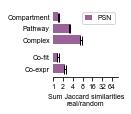

In [14]:
# plot enrichments of HI-III-PSN for localization, pathways, BioPlex, co-expression and co-fitness
datasets = []
networks = ['HI-III_PSN']
edge_weight = 'Jaccard_similarity'
fctPSN = ''
fctPSN_types = ['coAnnot','per_PCCcutoffs']
fct_nws = ['_SeekPSN','_coFitnessPSN']
xmin = 1
xmax = 100

for n,nw_name in enumerate(networks):
    for fctPSN_type in fctPSN_types:
        if fctPSN_type == 'per_PCCcutoffs':
            for fct_nw in fct_nws:
                datasets.append(get_fold_change_data(nw_name,path,edge_weight,fct_nw,fctPSN_type))
        else:
            datasets.append(get_fold_change_data(nw_name,path,edge_weight,fctPSN,fctPSN_type))

plt.figure(figsize=(1.8,1.6))
color = (110/255, 50/255, 120/255)
fold_changes = []
err_up = []
err_down = []
data = datasets[0]
fold_changes.append(data.loc[data['fct_dataset'] == 'cell_atlas_localization_info','foldchange'].values[0])
fold_changes.append(data.loc[data['fct_dataset'] == 'reactome_pathway_info','foldchange'].values[0])
fold_changes.append(data.loc[data['fct_dataset'] == 'Bioplex2.0_complex_info','foldchange'].values[0])
err_up.append(data.loc[data['fct_dataset'] == 'cell_atlas_localization_info','fc_err_up'].values[0])
err_up.append(data.loc[data['fct_dataset'] == 'reactome_pathway_info','fc_err_up'].values[0])
err_up.append(data.loc[data['fct_dataset'] == 'Bioplex2.0_complex_info','fc_err_up'].values[0])
err_down.append(data.loc[data['fct_dataset'] == 'cell_atlas_localization_info','fc_err_down'].values[0])
err_down.append(data.loc[data['fct_dataset'] == 'reactome_pathway_info','fc_err_down'].values[0])
err_down.append(data.loc[data['fct_dataset'] == 'Bioplex2.0_complex_info','fc_err_down'].values[0])
data = datasets[2]
fold_changes.append(data.loc[data['cutoff'] == 0.3,'foldchange'].values[0])
err_up.append(data.loc[data['cutoff'] == 0.3,'fc_err_up'].values[0])
err_down.append(data.loc[data['cutoff'] == 0.3,'fc_err_down'].values[0])
data = datasets[1]
fold_changes.append(data.loc[data['cutoff'] == 0.86,'foldchange'].values[0])
err_up.append(data.loc[data['cutoff'] == 0.86,'fc_err_up'].values[0])
err_down.append(data.loc[data['cutoff'] == 0.86,'fc_err_down'].values[0])

plt.barh([0,1,2,3.5,4.5],fold_changes,
        xerr=[err_down,err_up],
        height=0.8,color=hi_color,ecolor='black',error_kw={'elinewidth':1},capsize=4.5,label='PSN')

plt.yticks([0,1,2,3.5,4.5],['Compartment','Pathway','Complex','Co-fit','Co-expr'])
plt.ylim([-0.7,5.2])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0.)
ax.set_xscale('log', basex=2, nonposx='clip')
plt.xticks([2**i for i in range(0,7)],[2**i for i in range(0,7)])
plt.xlim(xmin=xmin,xmax=xmax)
plt.legend(loc='best',handlelength=1)
plt.xlabel('Sum Jaccard similarities\nreal/random')
ax.invert_yaxis()
plt.tight_layout()

filename = 'HI-III_PSN_overlap_with_coAnnot_fctnw_hori'
outfile = figure_path + filename + '.png'
plt.savefig(outfile,fmt='png',dpi=300)
outfile = figure_path + filename + '.pdf'
plt.savefig(outfile,fmt='pdf',dpi=300)

plt.show()